# Above 8 000: Data at Altitude

## Basic setup

### Import necessary libraries  

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Load information from the datasets

In [2]:
members = pd.read_csv('data\\members.csv',   low_memory=False)          # ~89 k rows
peaks   = pd.read_csv('data\\peaks.csv',     low_memory=False)          # ~480 rows
exped   = pd.read_csv('data\\exped.csv',     low_memory=False)          # ~11 k rows
refer   = pd.read_csv('data\\refer.csv',     encoding='latin1')         # ~16 k rows
ddict   = pd.read_csv('data\\himalayan_data_dictionary.csv')            # data dictionary

## Data Analysis

### How many expeditions took place in each year?

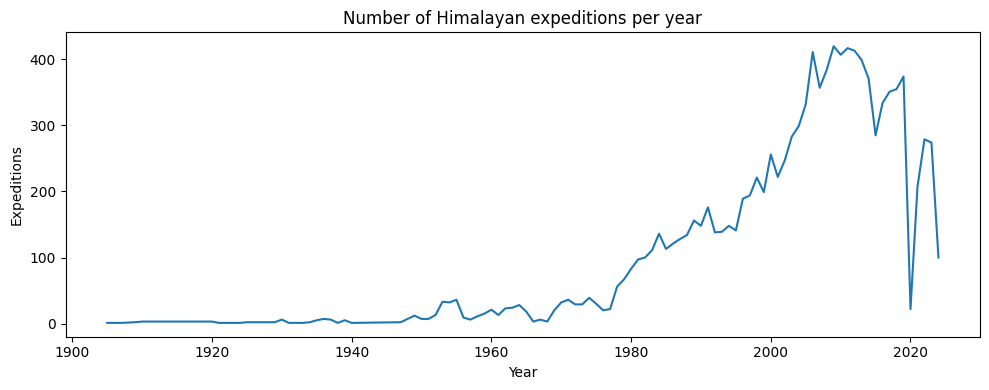

In [8]:
(exped["year"]
    .value_counts()
    .sort_index()
    .plot.line(
        figsize=(10,4),
        title="Number of Himalayan expeditions per year",
        xlabel="Year",
        ylabel="Expeditions"
    ))
plt.tight_layout()
plt.show()

### Oxygen use over time

In [ ]:
( members                                # DataFrame loaded from members.csv
    .dropna(subset=['myear'])            # just in case some rows lack a year
    .groupby('myear')['mo2used']         # every season’s climbers
    .mean()                              # True/False → share
    .mul(100)                            # turn into %
    .plot.line(
        figsize=(10,4),
        title='Share of Himalayan climbers using bottled oxygen, 1905-2024',
        ylabel='% of climbers',
        xlabel='Year'
    )
)

plt.tight_layout()
plt.show()

In [ ]:
climbers = (members
            .merge(peaks[['peakid', 'heightm']], on='peakid', how='left'))

climbers['class'] = np.where(climbers['heightm'] >= 8000,
                             '8000 m+', '<8000 m')

(climbers
   .dropna(subset=['myear'])                      # keep rows that have a year
   .groupby(['myear', 'class'])['mo2used']        # boolean → mean == share
   .mean()
   .mul(100)                                      # convert to %
   .unstack()                                     # rows=year, cols=class
   .plot.area(stacked=True,
              figsize=(10, 5),
              title='Share of climbers using bottled oxygen, by altitude class',
              xlabel='Year',
              ylabel='% of climbers')
)

plt.tight_layout()
plt.show()